In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import torch
from torch import nn, distributions
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Plot settings
rcParams['figure.figsize'] = 5, 5
rcParams['figure.dpi'] = 100


In [ ]:
class RealNVPBlock(nn.Module):
    def __init__(self, in_features, hidden_features):
        super(RealNVPBlock, self).__init__()
        self.net_s = nn.Sequential(
            nn.Linear(in_features // 2, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features * 2),
            nn.ReLU(),
            nn.Linear(hidden_features * 2, hidden_features * 2),
            nn.ReLU(),
            nn.Linear(hidden_features * 2, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, in_features // 2),
        )
        self.net_t = nn.Sequential(
            nn.Linear(in_features // 2, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, hidden_features * 2),
            nn.ReLU(),
            nn.Linear(hidden_features * 2, hidden_features * 2),
            nn.ReLU(),
            nn.Linear(hidden_features * 2, hidden_features),
            nn.ReLU(),
            nn.Linear(hidden_features, in_features // 2),
        )

    def forward(self, x):
        x_a, x_b = x.chunk(2, dim=1)
        s = self.net_s(x_a)
        t = self.net_t(x_a)
        y_a = x_a
        y_b = x_b * torch.exp(s) + t
        log_det_jacobian = s.sum(dim=1)
        return torch.cat([y_a, y_b], dim=1), log_det_jacobian

    def backward(self, y):
        y_a, y_b = y.chunk(2, dim=1)
        s = self.net_s(y_a)
        t = self.net_t(y_a)
        x_a = y_a
        x_b = (y_b - t) * torch.exp(-s)
        return torch.cat([x_a, x_b], dim=1)


In [ ]:
class RealNVP(nn.Module):
    def __init__(self, num_blocks, in_features, hidden_features):
        super(RealNVP, self).__init__()
        self.in_features = in_features
        self.blocks = nn.ModuleList([RealNVPBlock(in_features, hidden_features) for _ in range(num_blocks)])
        self.prior = distributions.MultivariateNormal(torch.zeros(in_features).to(device), torch.eye(in_features).to(device))

    def forward(self, x):
        log_det_jacobian = 0
        for block in self.blocks:
            x, ldj = block.forward(x)
            log_det_jacobian += ldj
            x = torch.flip(x, dims=(1,))
        return x, log_det_jacobian

    def backward(self, y):
        for block in reversed(self.blocks):
            y = torch.flip(y, dims=(1,))
            y = block.backward(y)
        return y

    def log_prob(self, x):
        y, log_det_jacobian = self.forward(x)
        log_prob_z = self.prior.log_prob(y)
        return log_prob_z + log_det_jacobian

    def sample(self, batch_size):
        y = self.prior.sample((batch_size,))
        x = self.backward(y)
        return x


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

def sample_target_distribution(num_samples):
    mu1 = np.array([2, 2])
    mu2 = np.array([-2, -2])
    sigma = np.array([[0.5, 0], [0, 0.5]])
    mixture = np.random.choice([0, 1], size=num_samples, p=[0.5, 0.5])
    samples = np.array([np.random.multivariate_normal(mu1, sigma) if m == 0 else np.random.multivariate_normal(mu2, sigma) for m in mixture])
    return torch.Tensor(samples)


In [ ]:
def train_real_nvp(model, data_loader, optimizer, num_epochs, visualize_epochs):
    model.train()
    train_loss = []
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0
        for x in data_loader:
            x = x.to(device)
            optimizer.zero_grad()
            loss = -model.log_prob(x).mean()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(data_loader)
        train_loss.append(avg_loss)

        if epoch + 1 in visualize_epochs:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}')
            with torch.no_grad():
                # Visualize the transformation to the base distribution
                z, _ = model.forward(target_samples.to(device))
                plot_samples(z.cpu(), f'Base Distribution at Epoch {epoch + 1}')
                # Visualize samples from the learned distribution
                generated_samples = model.sample(num_samples).cpu()
                plot_samples(generated_samples, f'Generated Samples at Epoch {epoch + 1}')

    return train_loss


In [ ]:
def plot_samples(samples, title):
    samples = samples.detach().numpy()
    plt.figure(figsize=(8, 8))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
    plt.title(title)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.show()


#MAIN

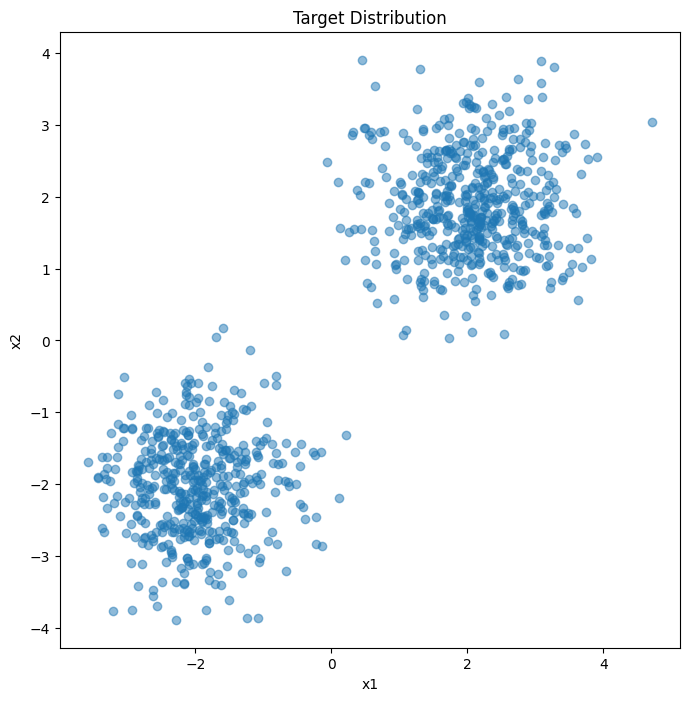

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch 1/4000, Loss: 3.8292


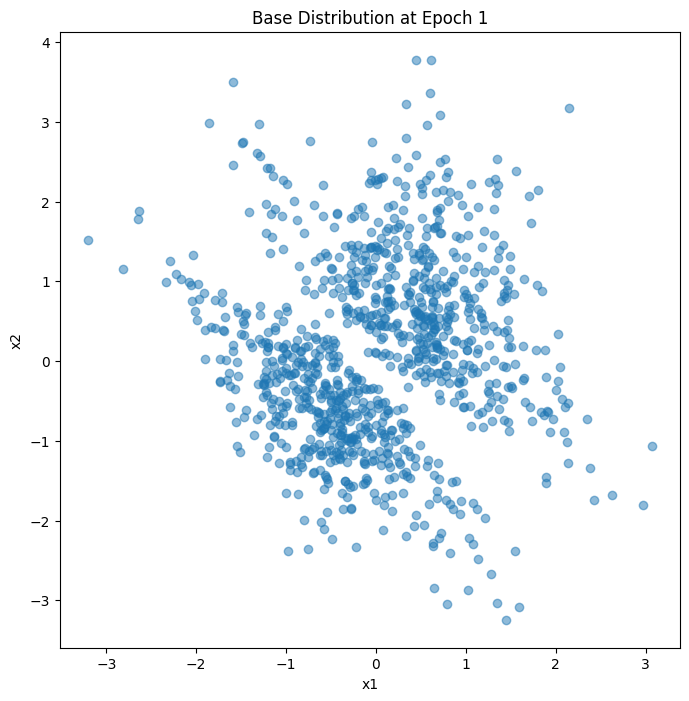

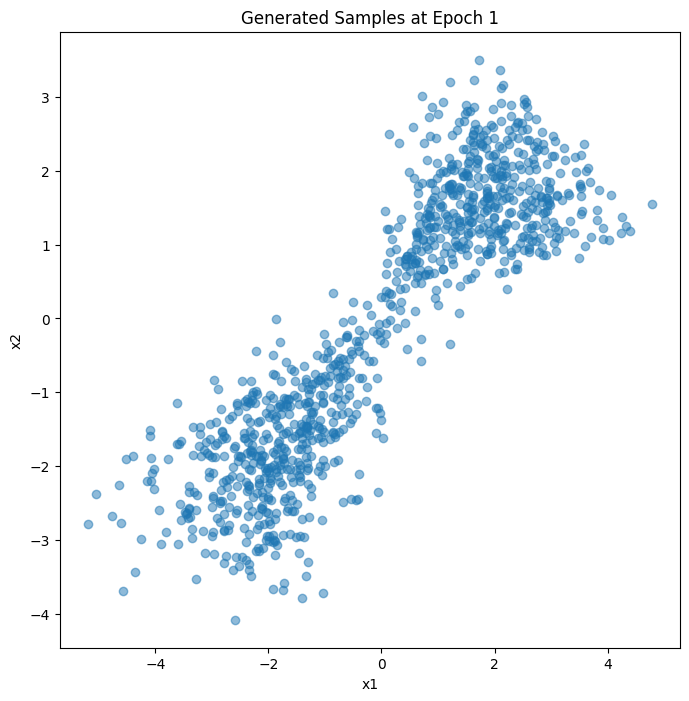

  0%|          | 9/4000 [00:08<57:07,  1.16it/s]

Epoch 10/4000, Loss: 2.9274


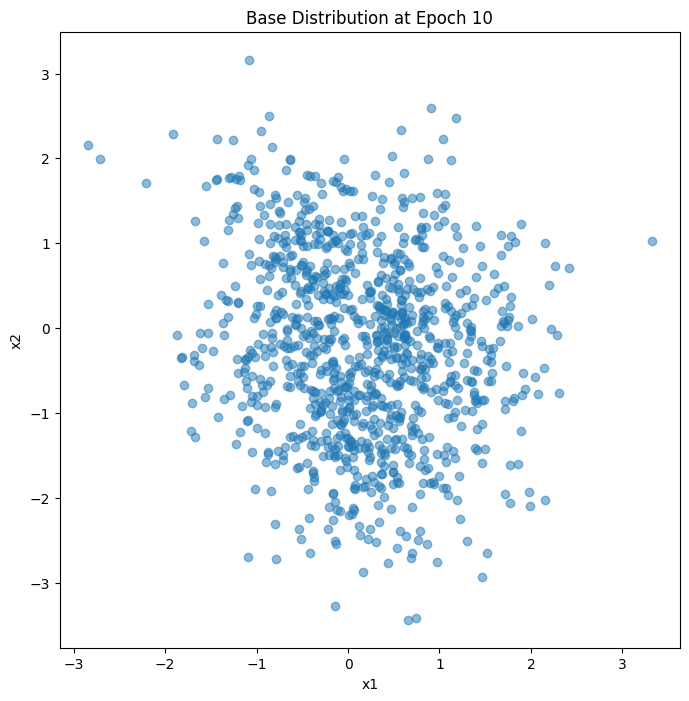

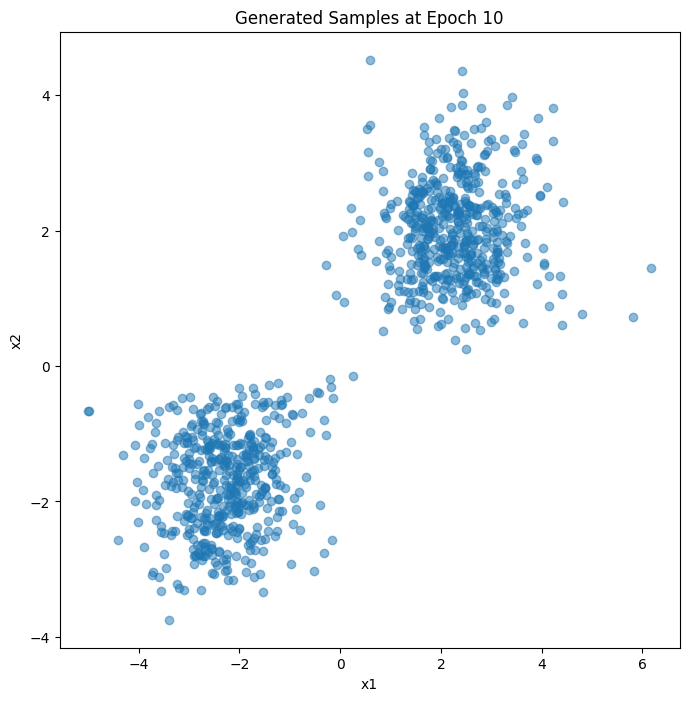

  2%|▏         | 99/4000 [01:27<1:07:40,  1.04s/it]

Epoch 100/4000, Loss: 2.8860


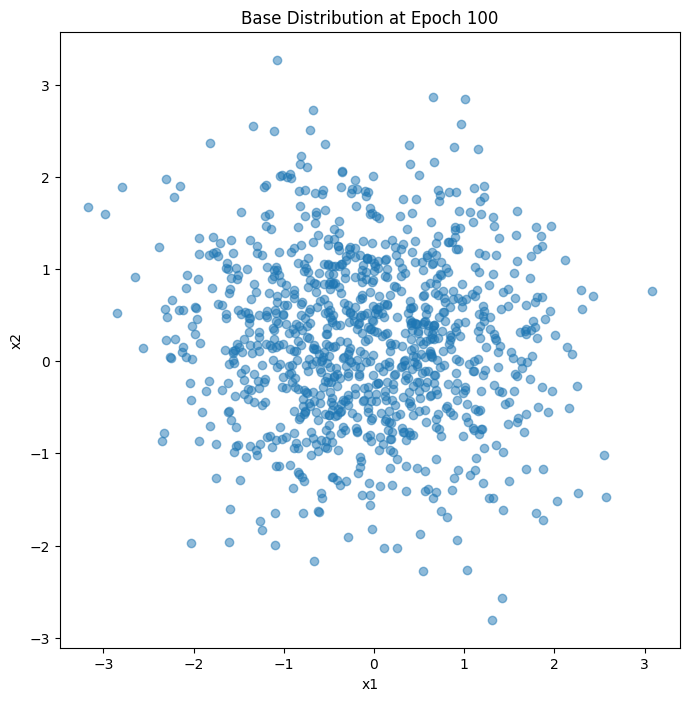

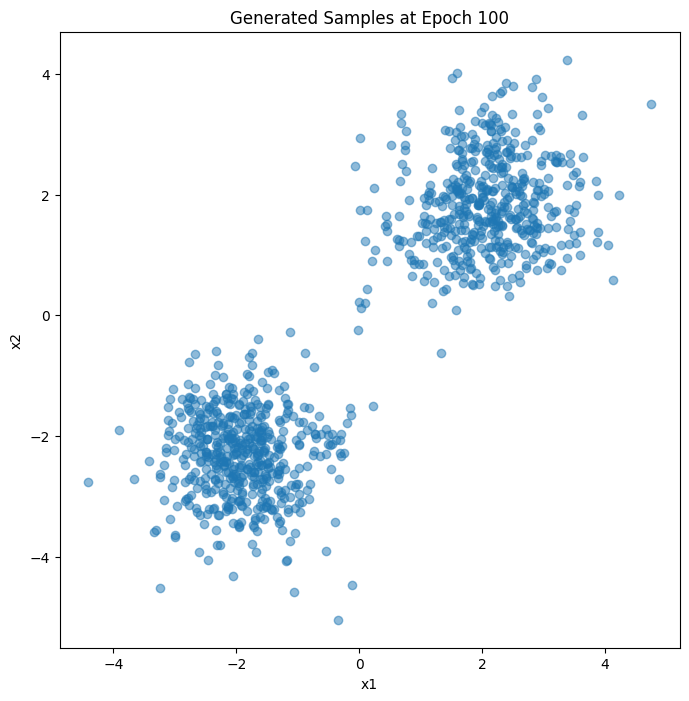

 12%|█▏        | 499/4000 [08:01<54:40,  1.07it/s]

Epoch 500/4000, Loss: 2.7945


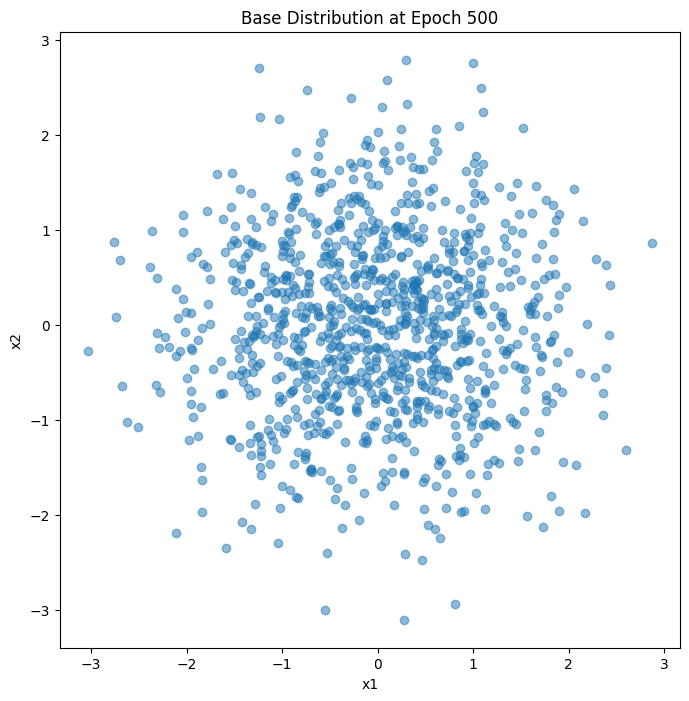

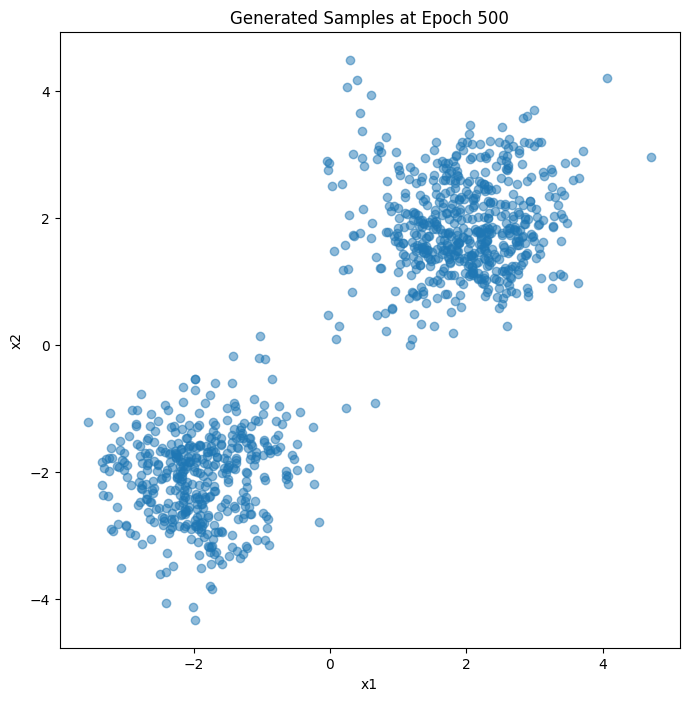

 25%|██▍       | 999/4000 [16:16<48:07,  1.04it/s]

Epoch 1000/4000, Loss: 2.8078


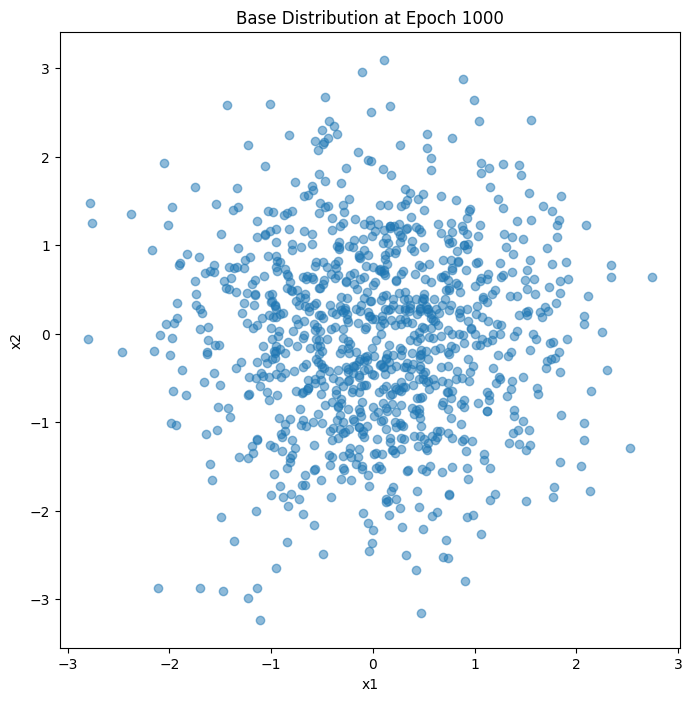

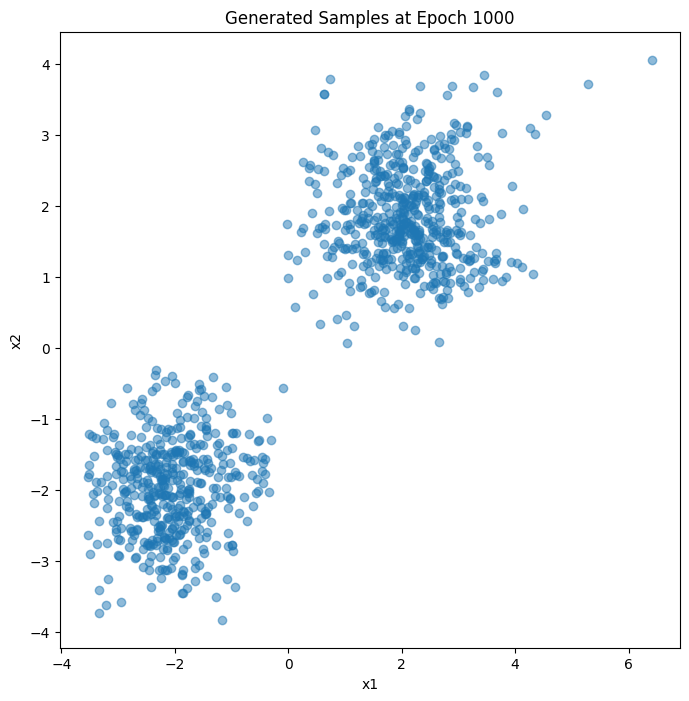

 37%|███▋      | 1499/4000 [24:30<46:31,  1.12s/it]

Epoch 1500/4000, Loss: 2.7821


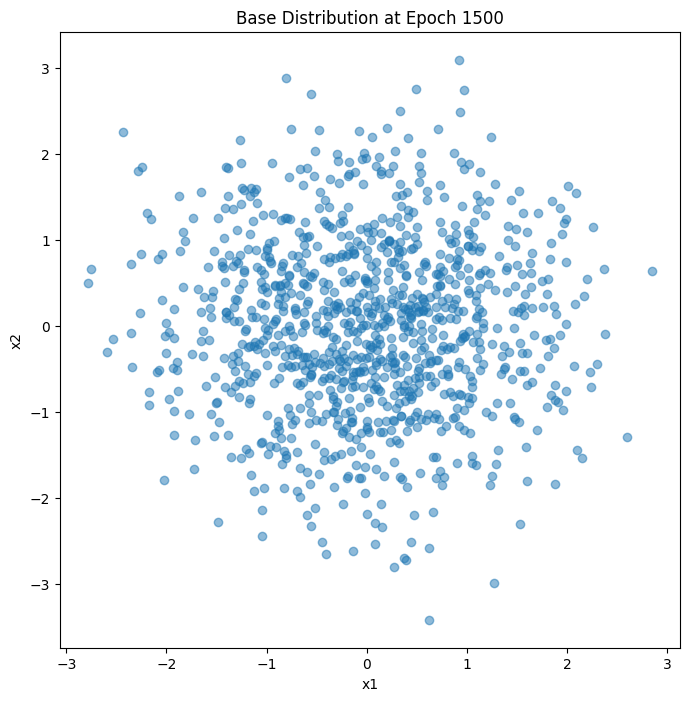

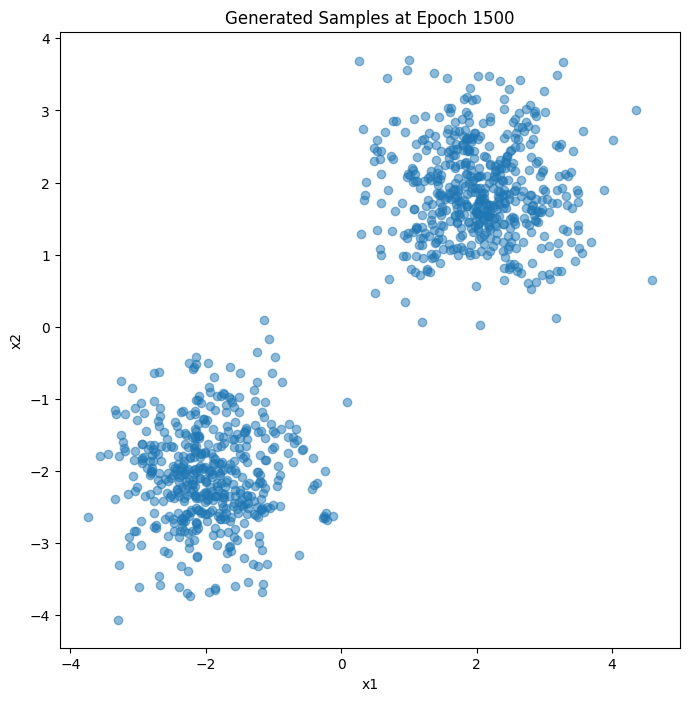

 50%|████▉     | 1999/4000 [33:07<34:45,  1.04s/it]

Epoch 2000/4000, Loss: 2.7704


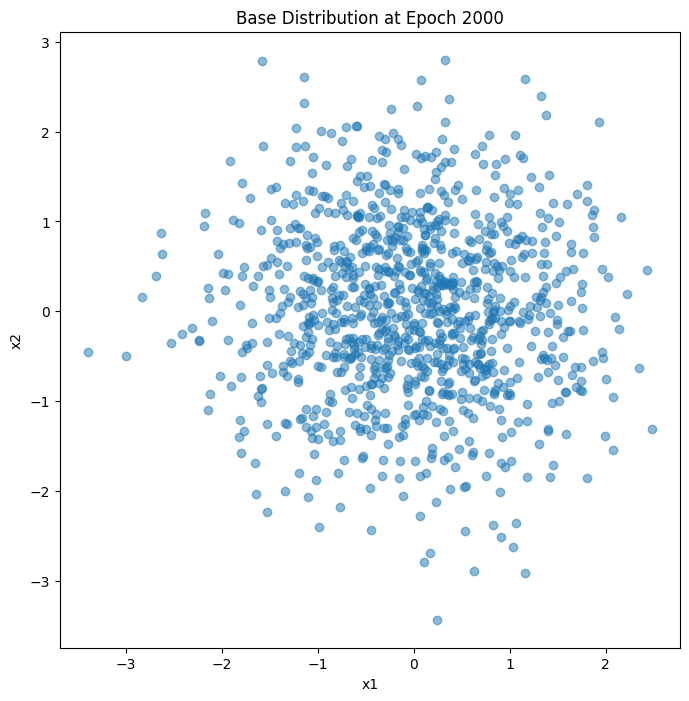

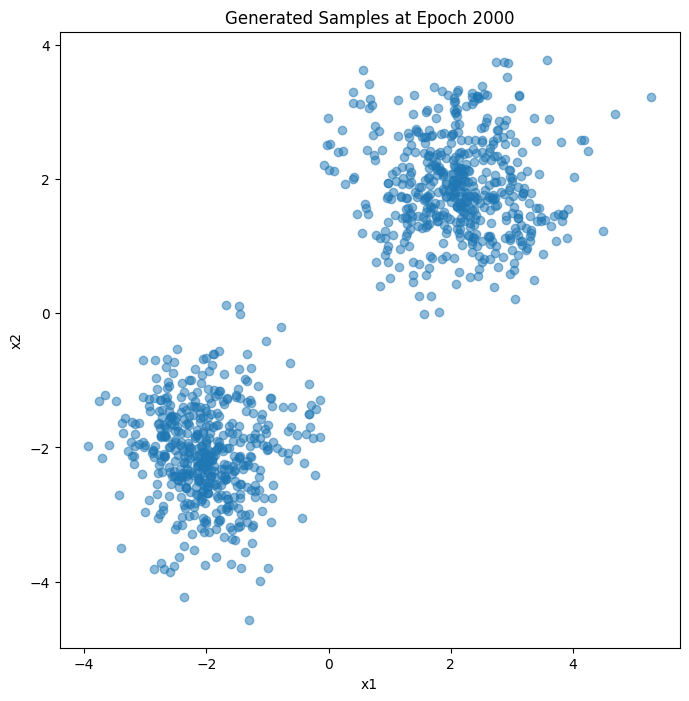

100%|█████████▉| 3999/4000 [1:14:29<00:01,  1.61s/it]

Epoch 4000/4000, Loss: 2.8049


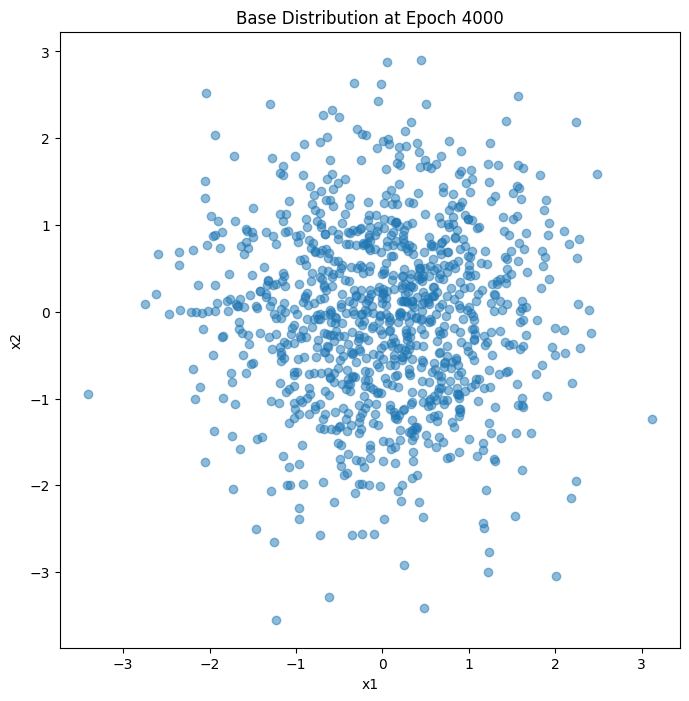

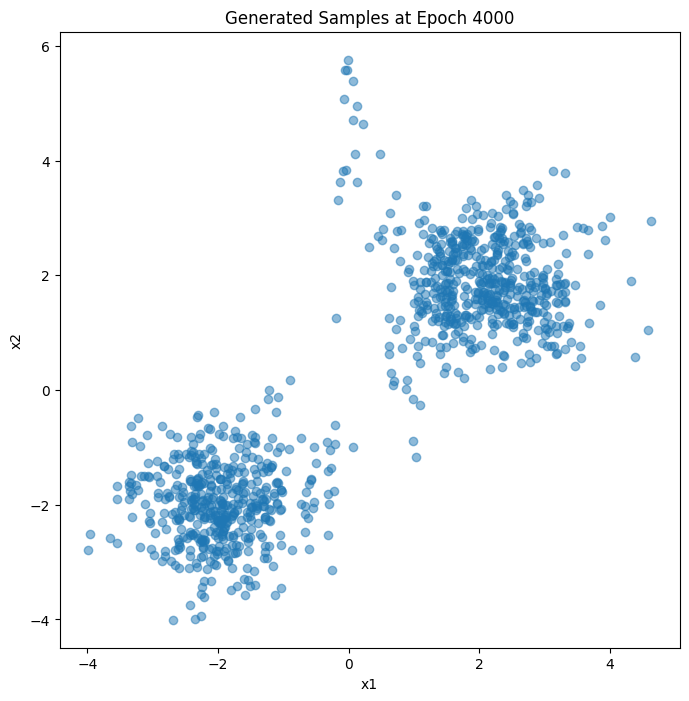

100%|██████████| 4000/4000 [1:14:31<00:00,  1.12s/it]


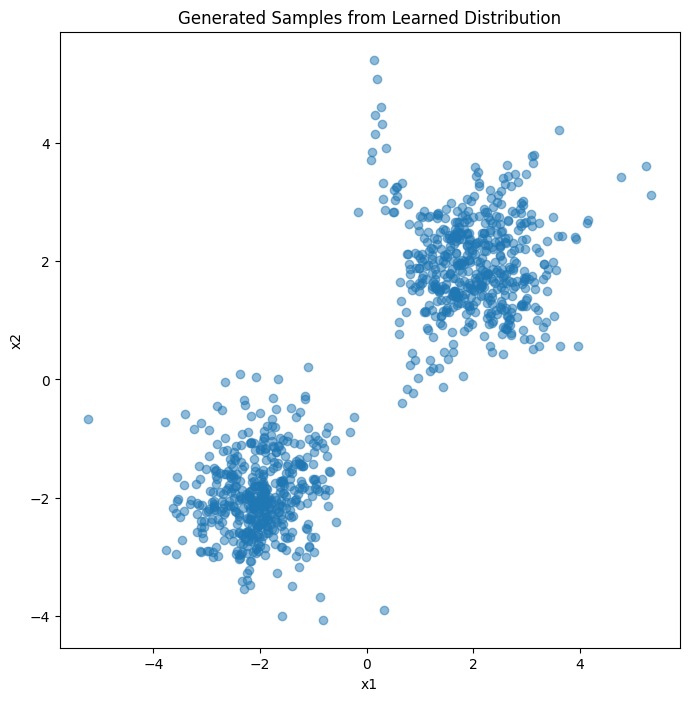

In [ ]:
num_samples = 1000
target_samples = sample_target_distribution(num_samples)
plot_samples(target_samples, 'Target Distribution')

batch_size = 64
data_loader = DataLoader(CustomDataset(target_samples), batch_size=batch_size, shuffle=True)

dim = 2
num_blocks = 6
hidden_features = 128
learning_rate = 0.001
num_epochs = 4000
visualize_epochs = [1, 10, 100, 500, 1000, 1500, 2000, 4000]

model = RealNVP(num_blocks, dim, hidden_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loss = train_real_nvp(model, data_loader, optimizer, num_epochs, visualize_epochs)

# Final visualization
generated_samples = model.sample(num_samples).cpu()
plot_samples(generated_samples, 'Generated Samples from Learned Distribution')
